# Everything you can do with a time series
- https://www.kaggle.com/thebrownviking20/everything-you-can-do-with-a-time-series#3.-Time-series-decomposition-and-Random-walks
- DS 스쿨 참고자료: https://datascienceschool.net/view-notebook/8959673a97214e8fafdb159f254185e9/

**DATA**            
**1. DJIA 30 Stock Time Series(주식 시계열 데이터)**

- 기간: 2006-01-01 ~ 2018-01-01(2017-12-31, 29,...)
- Data Columns
    - Date 형식 : yy-mm-dd
    - Open: 시장 개설시 주식 가격 (NYSE 데이터이므로 모두 USD로 표시)
    - High: 당일 최고 가격에 도달
    - Low Close(낮은 종가):하루에 도달 한 최저 가격
    - Volume(거래량): 거래 된 주식 수
    - Name: 주식 시세 이름

**2. Historical Hourly Weather Data 2012-2017 (시간별-시계열 기상 데이터)**
- 날씨 특성별 파일이 나눠져 있음.
- 모두 시간대별로 존재
- 온도, 습도, 기압, 풍속, 풍향, 도시별 위/경도

In [1]:
# import libaray
import os
# import warnings
# warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
from pylab import rcParams
from plotly import tools
import plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import math
from sklearn.metrics import mean_squared_error
print(os.listdir('./시계열_data'))

['DJIA 30 Stock Time Series', 'Historical Hourly Weather Data 2012-2017']


# Introduction to date and time

In [2]:
google = pd.read_csv('./시계열_data/DJIA 30 Stock Time Series/GOOGL_2006-01-01_to_2018-01-01.csv', index_col = 'Date', parse_dates=['Date'])
print(google.shape)
google.head()

(3019, 6)


,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL
2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL
2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL
2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL
2006-01-09,233.44,236.94,230.70,233.68,12795837,GOOGL


In [3]:
print(google.index.min())
print(google.index.max())

2006-01-03 00:00:00
2017-12-29 00:00:00


In [4]:
humidity = pd.read_csv('./시계열_data/Historical Hourly Weather Data 2012-2017/humidity.csv', index_col='datetime', parse_dates=['datetime'])
print(humidity.shape)
humidity.tail()

(45253, 36)


,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2017-11-29 20:00:00,NaN,81.0,NaN,93.0,24.0,72.0,18.0,68.0,37.0,18.0,...,27.0,NaN,64.0,37.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-29 21:00:00,NaN,71.0,NaN,87.0,21.0,72.0,18.0,73.0,34.0,12.0,...,29.0,NaN,59.0,74.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-29 22:00:00,NaN,71.0,NaN,93.0,23.0,68.0,17.0,60.0,32.0,15.0,...,31.0,NaN,66.0,74.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-29 23:00:00,NaN,71.0,NaN,87.0,14.0,63.0,17.0,33.0,30.0,28.0,...,26.0,NaN,58.0,56.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-30 00:00:00,NaN,76.0,NaN,75.0,56.0,72.0,17.0,23.0,34.0,31.0,...,32.0,NaN,58.0,56.0,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
print(humidity.index.min())
print(humidity.index.max())

2012-10-01 12:00:00
2017-11-30 00:00:00


## 결측치 처리(Cleaning)

In [6]:
google.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64

In [7]:
humidity.isnull().sum()

Vancouver            1826
Portland              449
San Francisco         942
Seattle               289
Los Angeles           152
San Diego             344
Las Vegas             842
Phoenix              1308
Albuquerque           710
Denver               1808
San Antonio           564
Dallas                319
Houston               121
Kansas City           512
Minneapolis           510
Saint Louis          1289
Chicago              1109
Nashville             567
Indianapolis          695
Atlanta               422
Detroit               862
Jacksonville          209
Charlotte             589
Miami                1087
Pittsburgh            522
Toronto               728
Philadelphia          624
New York             1624
Montreal             1696
Boston                449
Beersheba             859
Tel Aviv District    1113
Eilat                 970
Haifa                 818
Nahariyya             817
Jerusalem             906
dtype: int64

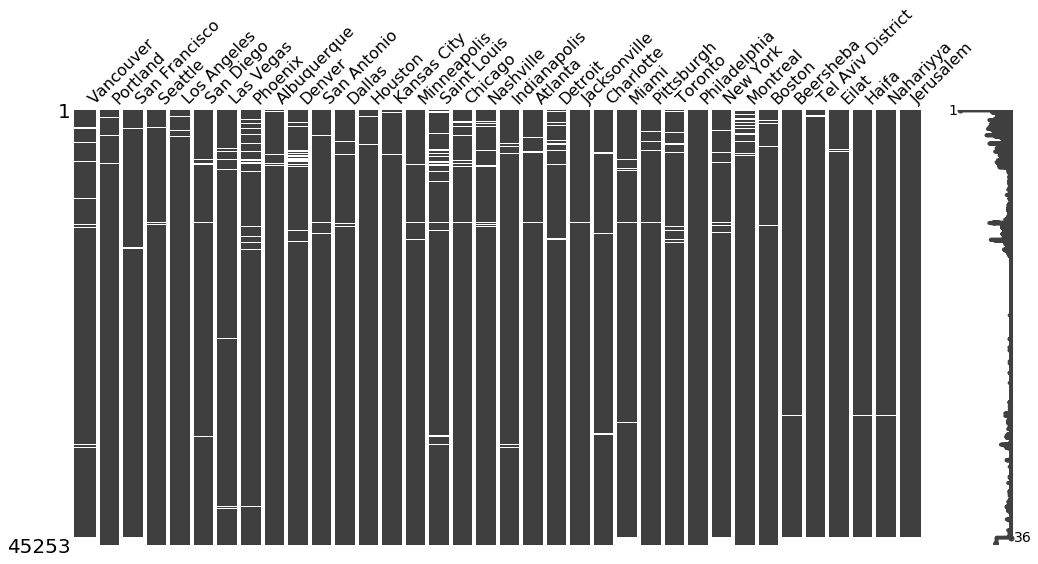

In [8]:
import missingno as msno
msno.matrix(df=humidity, figsize=(15,8))

- 도시별로 결측치 다수 존재하므로, 결측치 처리해주자!
- 마지막 유효 관측치를 전파하는 방식으로 처리

In [9]:
# filna()의 ffill(앞의 값으로 채움) 사용    # bfill or backfill은 뒤의 값으로 채움
humidity = humidity.iloc[1:]
humidity = humidity.fillna(method='ffill')
humidity.head()

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-01 13:00:00,76.0,81.0,88.0,81.0,88.0,82.0,22.0,23.0,50.0,62.0,...,71.0,58.0,93.0,68.0,50.0,63.0,22.0,51.0,51.0,50.0
2012-10-01 14:00:00,76.0,80.0,87.0,80.0,88.0,81.0,21.0,23.0,49.0,62.0,...,70.0,57.0,91.0,68.0,51.0,62.0,22.0,51.0,51.0,50.0
2012-10-01 15:00:00,76.0,80.0,86.0,80.0,88.0,81.0,21.0,23.0,49.0,62.0,...,70.0,57.0,87.0,68.0,51.0,62.0,22.0,51.0,51.0,50.0
2012-10-01 16:00:00,77.0,80.0,85.0,79.0,88.0,81.0,21.0,23.0,49.0,62.0,...,69.0,57.0,84.0,68.0,52.0,62.0,22.0,51.0,51.0,50.0
2012-10-01 17:00:00,78.0,79.0,84.0,79.0,88.0,80.0,21.0,24.0,49.0,63.0,...,69.0,57.0,80.0,68.0,54.0,62.0,23.0,51.0,51.0,50.0


In [10]:
humidity.tail()

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2017-11-29 20:00:00,87.0,81.0,22.0,93.0,24.0,72.0,18.0,68.0,37.0,18.0,...,27.0,58.0,64.0,37.0,57.0,60.0,100.0,96.0,96.0,60.0
2017-11-29 21:00:00,87.0,71.0,22.0,87.0,21.0,72.0,18.0,73.0,34.0,12.0,...,29.0,58.0,59.0,74.0,57.0,60.0,100.0,96.0,96.0,60.0
2017-11-29 22:00:00,87.0,71.0,22.0,93.0,23.0,68.0,17.0,60.0,32.0,15.0,...,31.0,58.0,66.0,74.0,57.0,60.0,100.0,96.0,96.0,60.0
2017-11-29 23:00:00,87.0,71.0,22.0,87.0,14.0,63.0,17.0,33.0,30.0,28.0,...,26.0,58.0,58.0,56.0,57.0,60.0,100.0,96.0,96.0,60.0
2017-11-30 00:00:00,87.0,76.0,22.0,75.0,56.0,72.0,17.0,23.0,34.0,31.0,...,32.0,58.0,58.0,56.0,57.0,60.0,100.0,96.0,96.0,60.0


In [11]:
humidity.isnull().sum()

Vancouver            0
Portland             0
San Francisco        0
Seattle              0
Los Angeles          0
San Diego            0
Las Vegas            0
Phoenix              0
Albuquerque          0
Denver               0
San Antonio          0
Dallas               0
Houston              0
Kansas City          0
Minneapolis          0
Saint Louis          0
Chicago              0
Nashville            0
Indianapolis         0
Atlanta              0
Detroit              0
Jacksonville         0
Charlotte            0
Miami                0
Pittsburgh           0
Toronto              0
Philadelphia         0
New York             0
Montreal             0
Boston               0
Beersheba            0
Tel Aviv District    0
Eilat                0
Haifa                0
Nahariyya            0
Jerusalem            0
dtype: int64

## Visualizing the datasets

- pandas의 asfreq() 메소드를 사용하면 pandas Period 객체를 원하는 주기(Period frequency)로 변환할 수 있습니다
    - M: 월단위

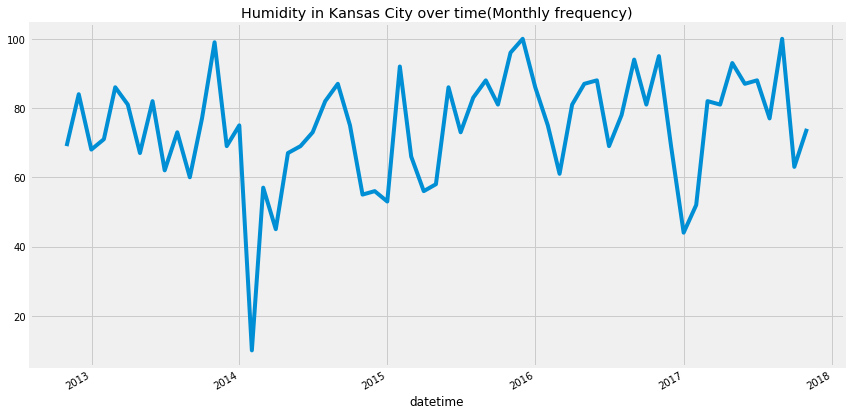

In [12]:
# 월별 습도 추이 (Kansas City)
f, ax = plt.subplots(1, figsize=(13, 7))
humidity['Kansas City'].asfreq('M').plot()  # monthly frequency
plt.title('Humidity in Kansas City over time(Monthly frequency)')
plt.show()

- 급감한 구간 제외하면, 습도의 계절성이 있는 것 같음 -> 추후 확인 필요

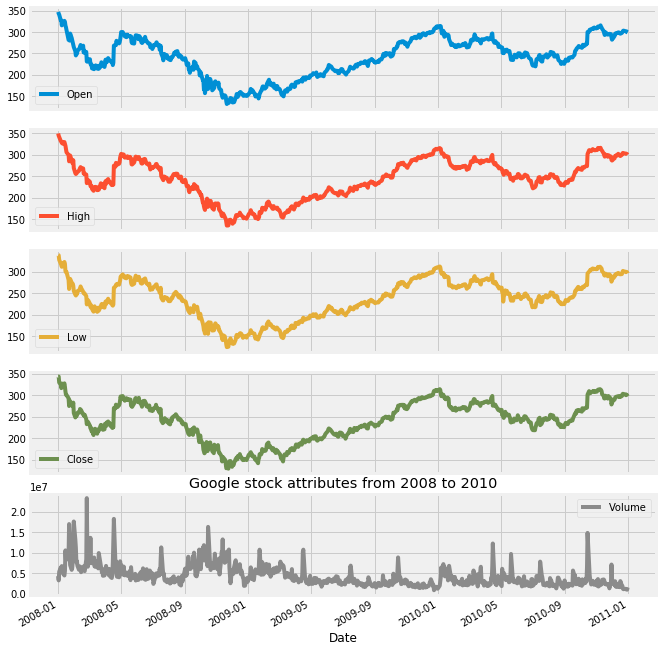

In [13]:
# 구글 주식 추이
google['2008':'2010'].plot(subplots=True, figsize=(10,12))  # subplots=True
plt.title('Google stock attributes from 2008 to 2010')
plt.savefig('stocks.png')
plt.show()

## [참고] datetime 관련 함수 알아보기

- date_range

In [14]:
# 시작, 끝 날자 지정하면, 해당 범위 날짜 알아서 생성
dr1 = pd.date_range(start='1/1/18', end = '1/9/18')
dr1

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09'],
              dtype='datetime64[ns]', freq='D')

In [15]:
# monthly frequency
# 해당 기간동안의 월별 마지막 날짜 반환
dr2 = pd.date_range(start='1/1/18', end='1/1/19', freq='M')
dr2

DatetimeIndex(['2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30',
               '2018-05-31', '2018-06-30', '2018-07-31', '2018-08-31',
               '2018-09-30', '2018-10-31', '2018-11-30', '2018-12-31'],
              dtype='datetime64[ns]', freq='M')

In [16]:
# periods 기간(day)전 부터 end날짜까지 반환
dr3 = pd.date_range(end='1/4/2014', periods=8)
dr3

DatetimeIndex(['2013-12-28', '2013-12-29', '2013-12-30', '2013-12-31',
               '2014-01-01', '2014-01-02', '2014-01-03', '2014-01-04'],
              dtype='datetime64[ns]', freq='D')

In [17]:
# start날짜부터 periods 기간(day)까지 반환
dr4 = pd.date_range(start='1/4/2014', periods=8)
dr4

DatetimeIndex(['2014-01-04', '2014-01-05', '2014-01-06', '2014-01-07',
               '2014-01-08', '2014-01-09', '2014-01-10', '2014-01-11'],
              dtype='datetime64[ns]', freq='D')

In [18]:
# start, end와 두 날짜를 를 periods 등분하는 날짜 반환
dr5 = pd.date_range(start='2013-04-24', end = '2014-11-27', periods=3)
dr5

DatetimeIndex(['2013-04-24', '2014-02-09', '2014-11-27'], dtype='datetime64[ns]', freq=None)

- to_datetime

In [19]:
df = pd.DataFrame({'year':[2015, 2016], 'month': [2,3], 'day': [4,5]})
df

,year,month,day
0,2015,2,4
1,2016,3,5


In [20]:
df = pd.to_datetime(df)
df

0   2015-02-04
1   2016-03-05
dtype: datetime64[ns]

In [21]:
df = pd.to_datetime('01-01-2017')
df

Timestamp('2017-01-01 00:00:00')

## Shifting and lags
- 선택적 시간 빈도로 원하는 기간 수만큼 인덱스를 이동할 수 있음
- 시계열을 과거의 과거와 비교할 때 유용

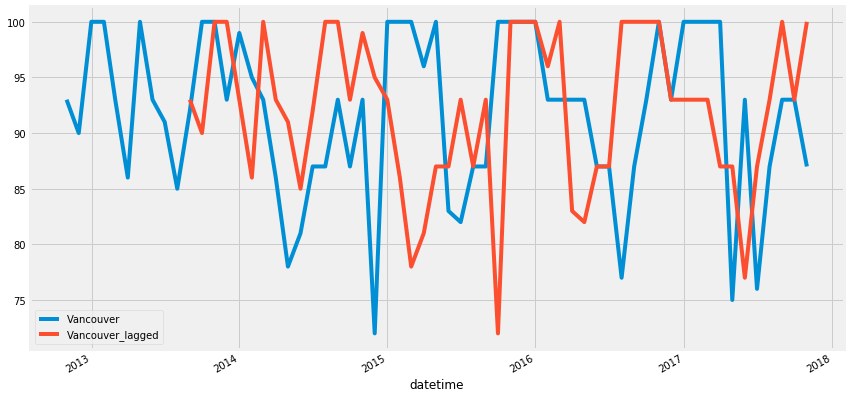

In [22]:
f, ax = plt.subplots(1, figsize=(13, 7))
humidity['Vancouver'].asfreq('M').plot(legend=True)
shifted = humidity['Vancouver'].asfreq('M').shift(10).plot(legend=True)
shifted.legend(['Vancouver','Vancouver_lagged'])
plt.show()

## Resampling
- Upsampling: 시계열 데이터를 낮은 빈도 -> 높은 빈도로 리샘플링됨
    - ex. 월별 -> 일별
    - 누락된 데이터 채우기 등
    
- Downsampling: 시계열을 높은 빈도 -> 낮은 빈도로 리샘플링
    - ex. 매주 -> 월별
    - 기존 데이터의 집계 등

In [24]:
# 날씨 - 도시별 기압 data
pressure = pd.read_csv('./시계열_data/Historical Hourly Weather Data 2012-2017/pressure.csv', index_col='datetime',parse_dates=['datetime'])
pressure.tail()

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2017-11-29 20:00:00,NaN,1031.0,NaN,1030.0,1016.0,1017.0,1021.0,1018.0,1025.0,1016.0,...,1021.0,NaN,1021.0,1017.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-29 21:00:00,NaN,1030.0,NaN,1030.0,1016.0,1017.0,1020.0,1018.0,1024.0,1018.0,...,1021.0,NaN,1023.0,1019.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-29 22:00:00,NaN,1030.0,NaN,1029.0,1015.0,1016.0,1020.0,1017.0,1024.0,1018.0,...,1022.0,NaN,1024.0,1019.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-29 23:00:00,NaN,1029.0,NaN,1028.0,1016.0,1016.0,1020.0,1016.0,1024.0,1020.0,...,1023.0,NaN,1026.0,1022.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-30 00:00:00,NaN,1029.0,NaN,1028.0,1015.0,1017.0,1019.0,1016.0,1024.0,1021.0,...,1024.0,NaN,1027.0,1023.0,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
pressure.isnull().sum()

Vancouver            4234
Portland                4
San Francisco         815
Seattle                13
Los Angeles           252
San Diego             175
Las Vegas              88
Phoenix               594
Albuquerque           456
Denver                543
San Antonio            17
Dallas                 60
Houston                 9
Kansas City           121
Minneapolis            17
Saint Louis            68
Chicago               725
Nashville             147
Indianapolis          289
Atlanta                49
Detroit                 5
Jacksonville           15
Charlotte               3
Miami                 794
Pittsburgh             46
Toronto               175
Philadelphia            4
New York             1041
Montreal              994
Boston                  7
Beersheba             806
Tel Aviv District     930
Eilat                 792
Haifa                 798
Nahariyya             795
Jerusalem             799
dtype: int64

    - 결측치 다수   ->  처리 필요

In [26]:
pressure = pressure.iloc[1:]  # datetime 행 뒤부터
pressure = pressure.fillna(method='ffill')
pressure.tail()

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2017-11-29 20:00:00,1021.0,1031.0,1013.0,1030.0,1016.0,1017.0,1021.0,1018.0,1025.0,1016.0,...,1021.0,1020.0,1021.0,1017.0,984.0,1011.0,968.0,1023.0,1023.0,1011.0
2017-11-29 21:00:00,1021.0,1030.0,1013.0,1030.0,1016.0,1017.0,1020.0,1018.0,1024.0,1018.0,...,1021.0,1020.0,1023.0,1019.0,984.0,1011.0,968.0,1023.0,1023.0,1011.0
2017-11-29 22:00:00,1021.0,1030.0,1013.0,1029.0,1015.0,1016.0,1020.0,1017.0,1024.0,1018.0,...,1022.0,1020.0,1024.0,1019.0,984.0,1011.0,968.0,1023.0,1023.0,1011.0
2017-11-29 23:00:00,1021.0,1029.0,1013.0,1028.0,1016.0,1016.0,1020.0,1016.0,1024.0,1020.0,...,1023.0,1020.0,1026.0,1022.0,984.0,1011.0,968.0,1023.0,1023.0,1011.0
2017-11-30 00:00:00,1021.0,1029.0,1013.0,1028.0,1015.0,1017.0,1019.0,1016.0,1024.0,1021.0,...,1024.0,1020.0,1027.0,1023.0,984.0,1011.0,968.0,1023.0,1023.0,1011.0


In [27]:
pressure.isnull().sum()    # Vancouver

Vancouver            20
Portland              0
San Francisco         0
Seattle               0
Los Angeles           0
San Diego             0
Las Vegas             0
Phoenix               0
Albuquerque           0
Denver                0
San Antonio           0
Dallas                0
Houston               0
Kansas City           0
Minneapolis           0
Saint Louis           0
Chicago               0
Nashville             0
Indianapolis          0
Atlanta               0
Detroit               0
Jacksonville          0
Charlotte             0
Miami                 0
Pittsburgh            0
Toronto               0
Philadelphia          0
New York              0
Montreal              0
Boston                0
Beersheba             0
Tel Aviv District     0
Eilat                 0
Haifa                 0
Nahariyya             0
Jerusalem             0
dtype: int64

In [28]:
pressure = pressure.fillna(method='bfill')
pressure.head()

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-01 13:00:00,807.0,1024.0,1009.0,1027.0,1013.0,1013.0,1018.0,1013.0,1024.0,1028.0,...,1014.0,1012.0,1001.0,1014.0,984.0,1012.0,1010.0,1013.0,1013.0,990.0
2012-10-01 14:00:00,807.0,1024.0,1009.0,1027.0,1013.0,1013.0,1018.0,1013.0,1024.0,1028.0,...,1014.0,1012.0,986.0,1014.0,984.0,1012.0,1010.0,1013.0,1013.0,990.0
2012-10-01 15:00:00,807.0,1024.0,1009.0,1028.0,1013.0,1013.0,1018.0,1013.0,1024.0,1028.0,...,1014.0,1012.0,945.0,1014.0,984.0,1012.0,1010.0,1013.0,1013.0,990.0
2012-10-01 16:00:00,807.0,1024.0,1009.0,1028.0,1013.0,1013.0,1018.0,1013.0,1024.0,1028.0,...,1014.0,1012.0,904.0,1014.0,984.0,1012.0,1010.0,1013.0,1013.0,990.0
2012-10-01 17:00:00,807.0,1024.0,1009.0,1029.0,1013.0,1013.0,1018.0,1013.0,1024.0,1028.0,...,1014.0,1012.0,863.0,1014.0,984.0,1012.0,1010.0,1013.0,1013.0,990.0


In [29]:
pressure.isnull().sum()

Vancouver            0
Portland             0
San Francisco        0
Seattle              0
Los Angeles          0
San Diego            0
Las Vegas            0
Phoenix              0
Albuquerque          0
Denver               0
San Antonio          0
Dallas               0
Houston              0
Kansas City          0
Minneapolis          0
Saint Louis          0
Chicago              0
Nashville            0
Indianapolis         0
Atlanta              0
Detroit              0
Jacksonville         0
Charlotte            0
Miami                0
Pittsburgh           0
Toronto              0
Philadelphia         0
New York             0
Montreal             0
Boston               0
Beersheba            0
Tel Aviv District    0
Eilat                0
Haifa                0
Nahariyya            0
Jerusalem            0
dtype: int64

In [30]:
# resampling
# 다운 샘플링 전 shape
pressure.shape

(45252, 36)

In [32]:
# hour -> 3day
# 시간당 기압을 3일 빈도로 다운 샘플링 (평균 집계)
pressure = pressure.resample('3D').mean()
pressure.head()

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-01,931.627119,1022.644068,1010.881356,1031.271186,1011.627119,1011.966102,1016.322034,1012.084746,1022.542373,1024.118644,...,1014.152542,1013.423729,937.627119,1013.677966,985.050847,1012.949153,1011.796610,1013.000000,1013.000000,990.525424
2012-10-04,1019.083333,1023.041667,1014.694444,1028.305556,1015.555556,1016.277778,1013.194444,1014.097222,1019.972222,1020.666667,...,1018.097222,1017.680556,1017.180556,1019.805556,984.930556,1013.083333,1012.611111,1013.000000,1013.000000,990.083333
2012-10-07,1013.930556,1017.444444,1016.597222,1018.736111,1013.416667,1014.222222,1012.888889,1011.861111,1005.833333,1020.458333,...,1017.958333,1016.750000,1014.152778,1016.305556,982.972222,1013.027778,1007.555556,1013.000000,1013.000000,989.833333
2012-10-10,1015.000000,1015.430556,1014.833333,1018.416667,1010.694444,1014.013889,1000.166667,1005.611111,986.000000,984.486111,...,1018.694444,1017.916667,1016.166667,1017.319444,979.763889,1006.527778,998.763889,1012.333333,1012.333333,987.888889
2012-10-13,1008.152778,1018.111111,1021.069444,1015.930556,1017.277778,1018.375000,1015.666667,1015.500000,1013.625000,1010.444444,...,1025.055556,1024.388889,1020.805556,1023.736111,984.527778,1013.027778,1007.194444,1013.000000,1013.000000,990.430556


In [38]:
pressure.shape    # 리샘플링 전보다 row 크게 줄어듬

(629, 36)

In [39]:
# upsampling (3day -> daily)
pressure = pressure.resample('D').pad()
pressure.head()

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-01,931.627119,1022.644068,1010.881356,1031.271186,1011.627119,1011.966102,1016.322034,1012.084746,1022.542373,1024.118644,...,1014.152542,1013.423729,937.627119,1013.677966,985.050847,1012.949153,1011.796610,1013.0,1013.0,990.525424
2012-10-02,931.627119,1022.644068,1010.881356,1031.271186,1011.627119,1011.966102,1016.322034,1012.084746,1022.542373,1024.118644,...,1014.152542,1013.423729,937.627119,1013.677966,985.050847,1012.949153,1011.796610,1013.0,1013.0,990.525424
2012-10-03,931.627119,1022.644068,1010.881356,1031.271186,1011.627119,1011.966102,1016.322034,1012.084746,1022.542373,1024.118644,...,1014.152542,1013.423729,937.627119,1013.677966,985.050847,1012.949153,1011.796610,1013.0,1013.0,990.525424
2012-10-04,1019.083333,1023.041667,1014.694444,1028.305556,1015.555556,1016.277778,1013.194444,1014.097222,1019.972222,1020.666667,...,1018.097222,1017.680556,1017.180556,1019.805556,984.930556,1013.083333,1012.611111,1013.0,1013.0,990.083333
2012-10-05,1019.083333,1023.041667,1014.694444,1028.305556,1015.555556,1016.277778,1013.194444,1014.097222,1019.972222,1020.666667,...,1018.097222,1017.680556,1017.180556,1019.805556,984.930556,1013.083333,1012.611111,1013.0,1013.0,990.083333


In [40]:
pressure.shape    # 업샘플링 전보다 row 늘어남

(1885, 36)

# Finance and statistics

## Percent change

In [41]:
google.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,211.47,218.05,209.32,217.83,13137450,GOOGL
2006-01-04,222.17,224.70,220.09,222.84,15292353,GOOGL
2006-01-05,223.22,226.00,220.97,225.85,10815661,GOOGL
2006-01-06,228.66,235.49,226.85,233.06,17759521,GOOGL
2006-01-09,233.44,236.94,230.70,233.68,12795837,GOOGL


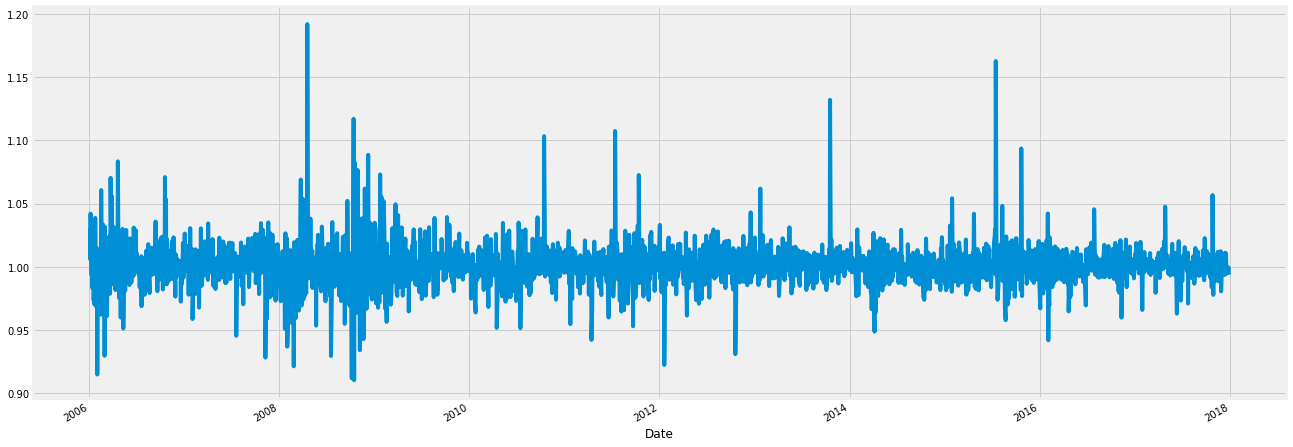

In [46]:
google['Change'] = google.High.div(google.High.shift(1))  # 오늘 high/전날 high
google['Change'].plot(figsize=(20,8))

In [47]:
google['Change']

Date
2006-01-03         NaN
2006-01-04    1.030498
2006-01-05    1.005785
2006-01-06    1.041991
2006-01-09    1.006157
                ...   
2017-12-22    0.994617
2017-12-26    0.997331
2017-12-27    0.999448
2017-12-28    0.996789
2017-12-29    0.993623
Name: Change, Length: 3019, dtype: float64

## Stock returns

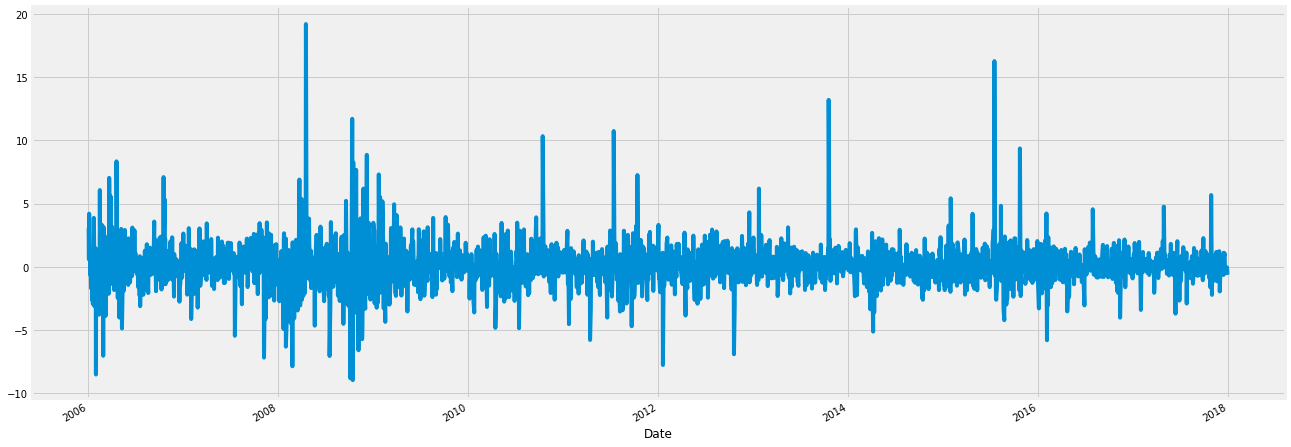

In [48]:
google['Return'] = google.Change.sub(1).mul(100)  #sub: -, mul: *
google['Return'].plot(figsize=(20,8))

In [49]:
google['Return']

Date
2006-01-03         NaN
2006-01-04    3.049759
2006-01-05    0.578549
2006-01-06    4.199115
2006-01-09    0.615737
                ...   
2017-12-22   -0.538273
2017-12-26   -0.266861
2017-12-27   -0.055199
2017-12-28   -0.321080
2017-12-29   -0.637654
Name: Return, Length: 3019, dtype: float64

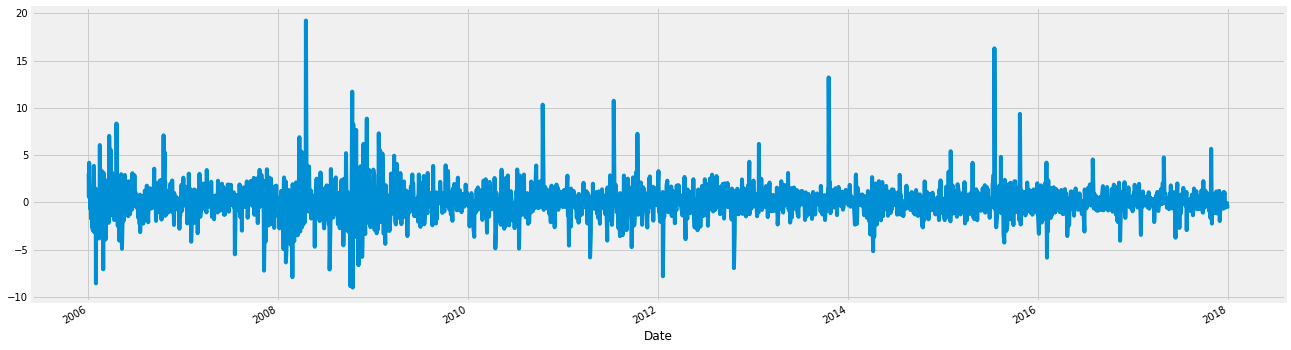

In [50]:
google.High.pct_change().mul(100).plot(figsize=(20,6)) # pct_change: 주가에 대한 수익 계산